In [33]:
# we use Pandas to work with the data as it makes working with categorical data very easy
import pandas as pd

In [40]:
# this is a list of the column names in our dataset (as the file doesn't contain any headers)
names = (
    'no_nota',
    'nomor_polisi',
    'nomor_rangka',
    'nomor_mesin',
    'tipe_motor',
    'tahun_produksi',
    'nama',
    'alamat',
    'phone',
    'agama',
    'pendidikan',
    'pekerjaan',
)

# some fields are categorical and will require special treatment
categorical = set((
    'no_nota',
    'nama',
    'alamat',
    'phone',
    'nomor_polisi',
    'nomor_rangka',
    'nomor_mesin',
    'tipe_motor',
    'nomor_polisi'
))

df = pd.read_csv("dataset.csv", sep=";", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

In [41]:
df.head()

,no_nota,nomor_polisi,nomor_rangka,nomor_mesin,tipe_motor,tahun_produksi,nama,alamat,phone,agama,pendidikan,pekerjaan
0,08332/KWT/20/01/00032,W4778ZX,MH1JM211XGK034452,JM21E1031855,BEAT,2018,KUSWORINI TITIK RAHAYU DRA,WONOKASIAN RT 004 RW 002 SIDOARJO,8.523060e+10,Islam,SMA/Sederajat,Wiraswasta
1,08332/KWT/20/02/00895,W4778ZX,MH1JM211XGK034452,JM21E1031855,BEAT,2018,KUSWORINI TITIK RAHAYU DRA,WONOKASIAN RT 004 RW 002 SIDOARJO,8.523060e+10,Islam,D4/S1,Wiraswasta
2,08332/KWT/20/01/00709,L3632MA,MH1KF112XJK447741,KF11E2438403,NEW VARIO 150,2018,JAMAL ILHAM IR,KEBONSARI V-B/6.B,8.123150e+08,Islam,SMA/Sederajat,Wiraswasta
3,08332/KWT/20/02/01105,W3446QF,MH1KC4113EK219894,KC41E1217620,ALL NEW CB150R STREETFIRE,2018,TEGUH,LARANGAN SUDIRMAN IX/25 CANDI SDA,8.225733e+10,Islam,S2,Wiraswasta
4,08332/KWT/20/02/01082,L5908ML,MH1KF411XKK699788,KF411702462,VARIO ESP CBS ISS ADV MMC,2019,MOHAMMAD RIZQI SE,MENANGGAL I REGENCY NO.19,8.564601e+10,Islam,SMA/Sederajat,Wiraswasta


In [42]:
# Mengubah kolom yang memiliki kategori ke bentuk numeric
df["agama"].replace({"Islam": 1, "Kristen Protestan": 2, "Katolik": 3, "Hindu": 4, "Budha": 5, "Khonghucu": 6}, inplace=True)
df["pendidikan"].replace({"Tidak Sekolah": 1, "SD": 2, "SMP/Sederajat": 3, "SMA/Sederajat": 4, "D1": 5, "D2": 6, "D3": 7, "D4/S1": 8, "S2": 9, "S3": 10}, inplace=True)
df["pekerjaan"].replace({"Tidak Bekerja": 1, "PNS": 2, "Wiraswasta": 3, "Pengusaha": 4, "Pegawai Pemerintah": 5, "Pensiunan": 6}, inplace=True)

df.head()

,no_nota,nomor_polisi,nomor_rangka,nomor_mesin,tipe_motor,tahun_produksi,nama,alamat,phone,agama,pendidikan,pekerjaan
0,08332/KWT/20/01/00032,W4778ZX,MH1JM211XGK034452,JM21E1031855,BEAT,2018,KUSWORINI TITIK RAHAYU DRA,WONOKASIAN RT 004 RW 002 SIDOARJO,8.523060e+10,1,4,3
1,08332/KWT/20/02/00895,W4778ZX,MH1JM211XGK034452,JM21E1031855,BEAT,2018,KUSWORINI TITIK RAHAYU DRA,WONOKASIAN RT 004 RW 002 SIDOARJO,8.523060e+10,1,8,3
2,08332/KWT/20/01/00709,L3632MA,MH1KF112XJK447741,KF11E2438403,NEW VARIO 150,2018,JAMAL ILHAM IR,KEBONSARI V-B/6.B,8.123150e+08,1,4,3
3,08332/KWT/20/02/01105,W3446QF,MH1KC4113EK219894,KC41E1217620,ALL NEW CB150R STREETFIRE,2018,TEGUH,LARANGAN SUDIRMAN IX/25 CANDI SDA,8.225733e+10,1,9,3
4,08332/KWT/20/02/01082,L5908ML,MH1KF411XKK699788,KF411702462,VARIO ESP CBS ISS ADV MMC,2019,MOHAMMAD RIZQI SE,MENANGGAL I REGENCY NO.19,8.564601e+10,1,4,3


In [43]:
for name in categorical:
    df[name] = df[name].astype('category')

**Implement a function that returns the spans (max-min for numerical columns, number of different values for categorical columns) of all columns for a partition of a dataframe.** 

In [44]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [45]:
full_spans = get_spans(df, df.index)
full_spans

{'agama': 4,
 'alamat': 863,
 'nama': 747,
 'no_nota': 1000,
 'nomor_mesin': 926,
 'nomor_polisi': 926,
 'nomor_rangka': 926,
 'pekerjaan': 5,
 'pendidikan': 7,
 'phone': 881,
 'tahun_produksi': 4,
 'tipe_motor': 84}

**Implement a `split` function that takes a dataframe, partition and column and returns two partitions that split the given partition such that all rows with values of the column `column` below the median are in one partition and all rows with values above or equal to the median are in the other.**

In [46]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

Now that we have all helper functions in place, we can implement the partition algorithm discussed above:

**Implement the partitioning algorithm discussed above, using a k-anonymous criterion for the partitions you create.**

In [47]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


Now let's try this on our dataset! To keep things simple, we will at first select only two columns from the dataset that we apply the partitioning to. This makes it easier to check/visualize the result and speed up the execution (the naive algorithm can take several minutes when running on the entire dataset) 

In [56]:
# we apply our partitioning method to two columns of our dataset, using "income" as the sensitive attribute
feature_columns = ['tahun_produksi','pekerjaan']
sensitive_column = 'tipe_motor'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [57]:
# we get the number of partitions that were created
len(finished_partitions)

7

Let's visualize the created partitions! To do that, we will write functions to get the rectangular bounds of a partition along two columns. We can then plot these rects to see how our partitioning function divides the dataset. If we perform the partition only along the two columns selected for plotting then the resulting rects should not overlap and cover the entire dataset.

In [58]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [59]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [60]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [61]:
# let's see how our rects look like
rects[:10]

[((2018.0, 1.0), (2019.0, 3.0)),
 ((2016.0, 3.0), (2018.0, 6.0)),
 ((2018.0, 3.0), (2019.0, 6.0)),
 ((2019.0, 1.0), (2020.0, 3.0)),
 ((2020.0, 1.0), (2020.0, 3.0)),
 ((2019.0, 3.0), (2020.0, 6.0)),
 ((2020.0, 3.0), (2020.0, 6.0))]

In [62]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

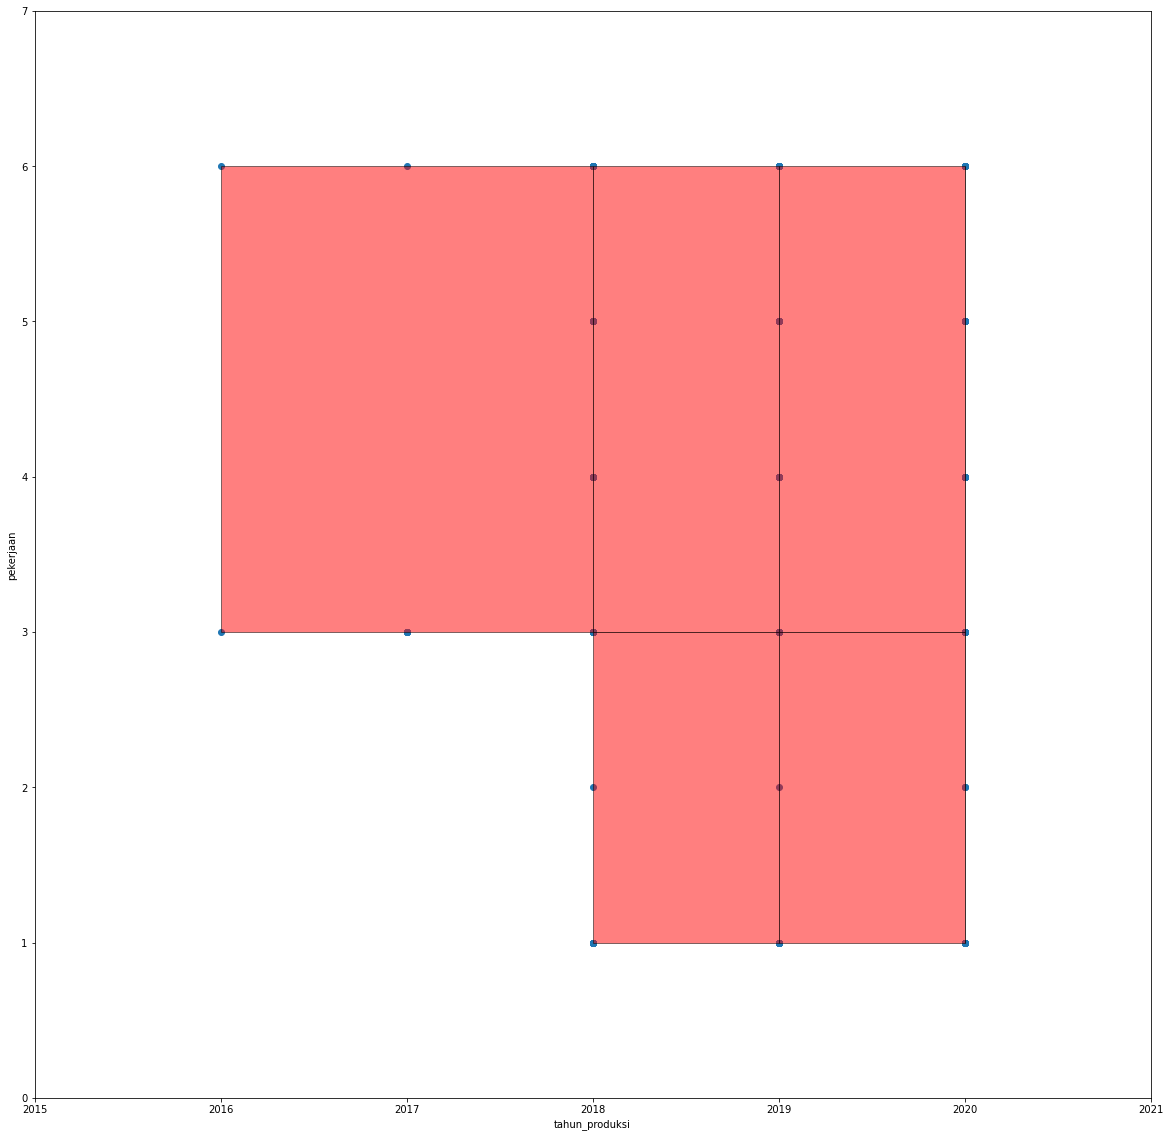

In [63]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

# Generating an k-Anonymous Dataset

Of course, to use the data we want to produce a new dataset that contains one row for each partition and value of the sensitive attribute. To do this, we need to aggregate the columns in each partition.  Let's do this!

In [64]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [65]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [66]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...


In [67]:
dfn.to_csv('anonymized_dataset.csv', index=False)
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])

,tahun_produksi,pekerjaan,tipe_motor,count
16,2016.777778,3.666667,VARIO ESP CBS ISS ADV MMC,1
17,2016.777778,3.666667,BEAT,3
18,2016.777778,3.666667,BEAT FI CW,1
19,2016.777778,3.666667,BLADE,1
20,2016.777778,3.666667,NEW BEAT SPOKE WHEEL,1
...,...,...,...,...
199,2020.000000,3.517564,VARIO 125 CBS-ISS MMC,4
200,2020.000000,3.517564,VARIO 150,6
201,2020.000000,3.517564,VARIO 150 MMC,1
202,2020.000000,3.517564,VERZA CAST WHEEL,2
